# Complex Network Analysis - Part 6
## Master in BigData: SNA Lab - Exercises

This notebook contains exercises on complex network analysis and graph modeling using NetworkX.

**Prerequisites:**
- `facebook.ncol` file should be available in the working directory
- All required libraries should be installed

In [1]:
# Import required libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib to display plots inline
%matplotlib inline

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


# Part 6. Assortativity, clustering, centrality, path length

## Exercise 1: Assortativity
Load the Karate Club graph and compute the degree assortativity coefficient. 


In [5]:
# Load the Karate Club graph 
G = nx.karate_club_graph()

# Compute the assortativity coefficient 
original_assortativity = nx.degree_assortativity_coefficient(G)


Create a copy of the graph with g.copy() and store it in a new variable.

Remove all edges where both nodes have degre >= 5
Recalculate the assortativity coefficient
How and why the assortativity changed?

In [6]:
degree_threshold = 5
G_modified = G.copy()
edges_to_remove = [(u, v) for u, v in G_modified.edges() if G.degree[u] >= degree_threshold and G.degree[v] >= degree_threshold]
G_modified.remove_edges_from(edges_to_remove)

# Recalculate assortativity after edge removal
modified_assortativity = nx.degree_assortativity_coefficient(G_modified)

print(f"Original Assortativity Coefficient: {original_assortativity:.4f}")
print(f"Assortativity Coefficient (after removing edges): {modified_assortativity:.4f}")

Original Assortativity Coefficient: -0.4756
Assortativity Coefficient (after removing edges): -0.4417


This may seem counterintuitive!

You might expect more high–low connections = more disassortativity.
Actually, removing the high–high connections reduces the degree correlation variability. In the assortativity formula, this can reduce the overall negative correlation slightly, leading to a less negative value (closer to zero).

In short:

By removing the few edges that counteracted the disassortative trend, you reduce overall variability, which paradoxically softens the disassortativity slightly.

## Exercise 2: Multi-Centrality analysis
- Compute centrality measures (degree, closeness, betweenness)
- Find the top 5 nodes for each centrality measure 
- Create a comparison DataFrame showing which nodes appear in multiple "top 5" lists

In [ ]:
import pandas as pd

# Compute centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Get top 5 nodes for each centrality
def get_top_n(centrality_dict, n=5):
    return sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:n]

top_degree = get_top_n(degree_centrality)
top_closeness = get_top_n(closeness_centrality)
top_betweenness = get_top_n(betweenness_centrality)

# Create a DataFrame to display the top nodes for each centrality measure
top_nodes = pd.DataFrame(index=range(1, 6))
top_nodes['Degree Centrality'] = [node for node, _ in top_degree]
top_nodes['Closeness Centrality'] = [node for node, _ in top_closeness]
top_nodes['Betweenness Centrality'] = [node for node, _ in top_betweenness]

top_nodes

,Degree Centrality,Closeness Centrality,Betweenness Centrality
1,33,0,0
2,0,2,33
3,32,33,32
4,2,31,2
5,1,8,31


now, remove the most central node according to betweenness **from a copy of the graph**. Is the graph still connected? 

In [8]:
most_central_node = 0

# Remove the most central node from a copy of the graph
G_removed = G.copy()
G_removed.remove_node(most_central_node)

# Check if the graph is still connected
is_connected = nx.is_connected(G_removed)
print(f"Is the graph still connected after removing node {most_central_node}? {is_connected}")

Is the graph still connected after removing node 0? False


Calculate average shortest path length on the original graph.
Then, find the largest connected component of the second graph and compute its avg shortest path length.

In [19]:

# Calculate average shortest path length
avg_shortest_path_length = nx.average_shortest_path_length(G)
print(f"Average shortest path length: {avg_shortest_path_length:.4f}")

# Calculate average shortest path length after removing the most central node
lcc = max(nx.connected_components(G_removed), key=len)
G_lcc = G_removed.subgraph(lcc)
avg_shortest_path_length_lcc = nx.average_shortest_path_length(G_lcc)
print(f"Average shortest path length in the largest connected component after removal: {avg_shortest_path_length_lcc:.4f}")

Average shortest path length: 2.4082
Average shortest path length in the largest connected component after removal: 2.2792



## Exercise 3: Clustering
Load the facebook network. Compute clustering values for all nodes. Plot a histogram showing the clustering distribution

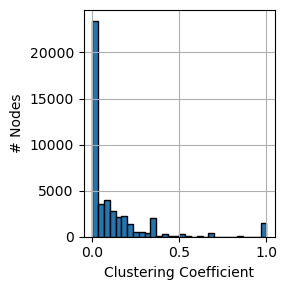

In [30]:
G = nx.read_weighted_edgelist("facebook.ncol", create_using=nx.Graph(), nodetype=int)
clustering_coeffs = nx.clustering(G)

# Create a histogram of clustering coefficients
plt.figure(figsize=(3, 3))
plt.hist(clustering_coeffs.values(), bins=30, edgecolor='black')

plt.xlabel("Clustering Coefficient")
plt.ylabel("# Nodes")
plt.grid(True)
plt.tight_layout()
plt.show()


Who are the nodes with high/low clustering? Make a scatterplot with node degrees on the X axis and clustering coefficients on the y axis


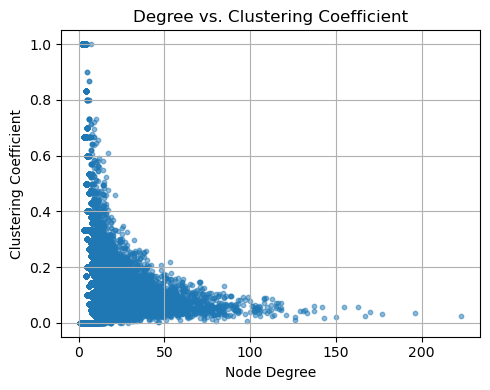

In [29]:
# Scatterplot of node degree vs. clustering coefficient
degrees = [G.degree[node] for node in clustering_coeffs.keys()]
clustering_values = list(clustering_coeffs.values())

plt.figure(figsize=(5, 4))
plt.scatter(degrees, clustering_values, alpha=0.5, s=10)
plt.xlabel("Node Degree")
plt.ylabel("Clustering Coefficient")
plt.title("Degree vs. Clustering Coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

## Exercise 4: Local vs. Global homophily

On the Karate Club graph:
- compute attribute assortativity on the 'club' attribute with  nx.attribute_assortativity_coefficient(G, 'club')
- write a function that inputs the graph and a node, and outputs the fraction of neighbors with the same attribute value of the node. Recall that you can access node n's attribute with g.nodes[n].get(attribute_name)
- test it on node 0, which should output 0.94

In [10]:
G = nx.karate_club_graph()
# Compute attribute assortativity for the Karate Club graph
# The attribute is 'club' (either 'Mr. Hi' or 'Officer')
attribute_assortativity = nx.attribute_assortativity_coefficient(G, 'club')
print(f"Attribute assortativity (club): {attribute_assortativity:.4f}")

# Function to compute local homophily for a given node
def local_homophily(graph, node, attribute):
    node_value = graph.nodes[node].get(attribute)
    neighbors = list(graph.neighbors(node))
    neigh_attrs = [graph.nodes[n].get(attribute) for n in neighbors]
    same = sum(1 for attr in neigh_attrs if attr == node_value)
    return same / len(neighbors)

# Example usage: compute local homophily for node 0
fraction_same_club = local_homophily(G, 0, 'club')
print(f"Fraction of neighbors of node 0 with the same club: {fraction_same_club:.2f}")

Attribute assortativity (club): 0.7175
Fraction of neighbors of node 0 with the same club: 0.94


Compute it for all nodes and plot a histogram with the distribution of local homophily.

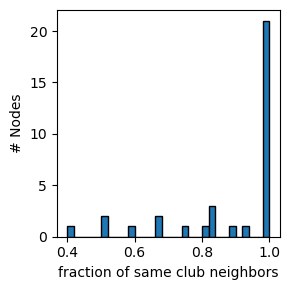

In [11]:
# Compute local homophily for all nodes in the Karate Club graph
local_homophily_values = [
    local_homophily(G, node, 'club') for node in G.nodes()
]

# Plot histogram of local homophily values
plt.figure(figsize=(3, 3))
plt.hist(local_homophily_values, bins=30, edgecolor='black')
plt.xlabel("fraction of same club neighbors")
plt.ylabel("# Nodes")
plt.tight_layout()
plt.show()

In [ ]:
# --------------- dependencies ---------------
# If you already have HyperGraphX installed you can switch the two commented lines
# and let HGX handle the heavy lifting.  The fallback below relies only on NetworkX
# so it will run in any standard Python / Jupyter environment.
#
# import hypergraphx as hgx
# H_class = hgx.Hypergraph
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import hypergraphx as hgx
H_class = hgx.Hypergraph
# --------------- the toy snapshots ---------------
edges_t1 = [
    {"Alice","Bob","Carol"},
    {"Alice","Bob","Dave"},
    {"Bob","Eve"},
    {"Alice","Frank"},
    {"Alice","Bob","Carol","Dave"},
    {"Bob","Carol","Eve","Frank"},
    {"Alice","Eve","Greg"},
    {"Henry","Isla"}
]
edges_t2 = [
    {"Alice","Bob","Carol"},
    {"Alice","Bob","Dave"},
    {"Bob","Eve"},
    {"Alice","Frank","Greg"},
    {"Alice","Bob","Carol","Eve"},
    {"Bob","Carol","Eve","Frank"},
    {"Alice","Eve","Greg"},
    {"Henry","Isla"}
]
edges_t3 = [
    {"Alice","Bob","Carol"},
    {"Alice","Bob","Eve"},
    {"Bob","Eve","Frank"},
    {"Alice","Greg"},
    {"Alice","Bob","Dave","Eve"},
    {"Bob","Carol","Eve","Frank"},
    {"Alice","Eve","Frank","Greg"},
    {"Henry","Isla"}
]
snapshots = [edges_t1, edges_t2, edges_t3]
titles     = ["t₁ (first snapshot)", "t₂ (second snapshot)", "t₃ (third snapshot)"]

# --------------- layout (computed *once*) ---------------
all_nodes = set().union(*[set().union(*s) for s in snapshots])
layout_graph = nx.Graph()
layout_graph.add_nodes_from(all_nodes)
for edge in itertools.chain(*snapshots):
    layout_graph.add_edges_from(itertools.combinations(edge, 2))  # clique-expansion just to guide the spring layout
pos = nx.spring_layout(layout_graph, seed=42)  # fixed by seed → identical across all plots

# --------------- drawing helper ---------------
def draw_snapshot(edge_list, title):
    """
    Very light-weight hypergraph visualisation:
    * every hyperedge is drawn as the clique on its nodes
      (good enough for didactic examples without installing extra libs)
    """
    G = nx.Graph()
    G.add_nodes_from(all_nodes)
    for e in edge_list:
        G.add_edges_from(itertools.combinations(e, 2))

    plt.figure(figsize=(6,4))
    nx.draw_networkx_nodes(G, pos, node_size=500)      # default matplotlib colours (no manual styling)
    nx.draw_networkx_labels(G, pos, font_size=8)
    nx.draw_networkx_edges(G, pos, alpha=.30)
    plt.title(title)
    plt.axis("off")
    plt.show()

# --------------- render the three figures ---------------
for edges, ttl in zip(snapshots, titles):
    draw_snapshot(edges, ttl)
